In [28]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.image_classification.models import ResNet
from torchvision import transforms
from tqdm import tqdm

# Setting

In [29]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [30]:
artifact_path = Path("../../artifacts/resnet")
data_path = Path("../../data/animal10")

In [31]:
device = torch.device("cuda:0")

# data

In [32]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [33]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [34]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [35]:
num_class = len(dataset.classes)

# model

In [36]:
model = ResNet(output_size=num_class, num_layer=50).to(device)

In [37]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
ResNet                                             --
├─Sequential: 1-1                                  --
│    └─ConvBnRelu: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─BottleNeck: 3-4                        58,112
│    │    └─ConvBnRelu: 3-5                        16,896
│    └─ResBlock: 2-4                               --
│    │    └─BottleNeck: 3-6                        70,400
│    │    └─Identity: 3-7                          --
│    └─ResBlock: 2-5                               --
│    │    └─BottleNeck: 3-8                        70,400
│    │    └─Identity: 3-9                          --
├─S

# training

In [38]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [39]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [40]:
training_loss = []

model.train()
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

100%|██████████| 1636/1636 [04:39<00:00,  5.84it/s]


epoch 1: 0.032176847903730946


100%|██████████| 1636/1636 [04:43<00:00,  5.78it/s]


epoch 2: 0.028110389810062184


100%|██████████| 1636/1636 [04:43<00:00,  5.77it/s]


epoch 3: 0.025668095604767478


100%|██████████| 1636/1636 [04:56<00:00,  5.52it/s]


epoch 4: 0.02375792081951025


100%|██████████| 1636/1636 [04:48<00:00,  5.68it/s]


epoch 5: 0.022512893380271435


100%|██████████| 1636/1636 [04:50<00:00,  5.63it/s]


epoch 6: 0.02107753414109846


100%|██████████| 1636/1636 [04:33<00:00,  5.97it/s]


epoch 7: 0.01999660179009298


100%|██████████| 1636/1636 [04:32<00:00,  6.01it/s]


epoch 8: 0.018937925457751772


100%|██████████| 1636/1636 [04:35<00:00,  5.95it/s]


epoch 9: 0.017812709400014875


100%|██████████| 1636/1636 [04:30<00:00,  6.06it/s]

epoch 10: 0.016961729453035687


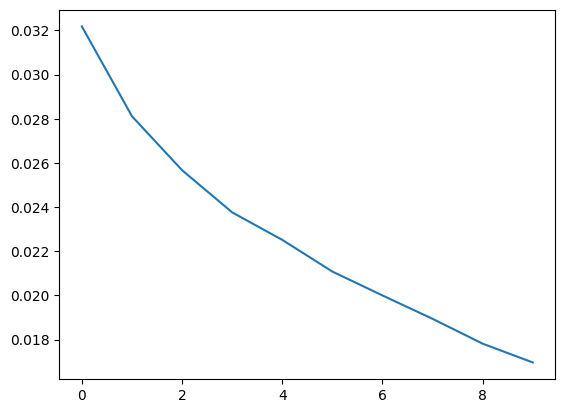

In [41]:
plt.plot(training_loss)

# inference

In [42]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE*2, IMAGE_SIZE*2)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [43]:
test_dataset = torchvision.datasets.ImageFolder(data_path.as_posix(), transform=test_preprocess)

In [44]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [45]:
evaluator = ClassificationEvaluator(num_class, device)

In [46]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 1637/1637 [07:07<00:00,  3.83it/s]


In [47]:
print(confusion_matrix)

[[3783  164   94   68   64  129  110  100  277   74]
 [ 480 1630  109   15   32    5  202   68   70   12]
 [ 101  113 1108    8   11    1   21   47   22   14]
 [  57   12    8 1327   17   11    8    7  643   22]
 [ 301   91   55   53 2119   35   31   48  334   31]
 [ 677    8   55   19    8  647    9   13  128  104]
 [ 275  318   39    6   19    0  999  165   40    5]
 [ 189   64  138    3   24   23  172 1087   77   43]
 [ 141   35   31   49   10    7   16   39 4454   39]
 [ 240   63   46   11   20   73   17   66  430  896]]


In [48]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.7779148673658236
cavallo   : 0.621425848265345
elefante  : 0.7662517289073306
farfalla  : 0.6283143939393939
gallina   : 0.683989670755326
gatto     : 0.38788968824940045
mucca     : 0.5353697749196141
pecora    : 0.5972527472527472
ragno     : 0.9238747147894628
scoiattolo: 0.48120300751879697


In [49]:
per_class_acc.mean()

0.640348644196324

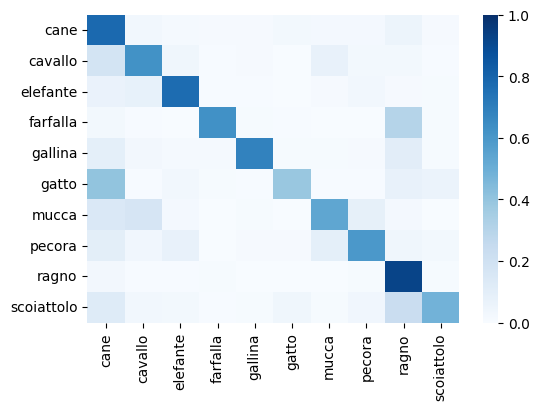

In [53]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [56]:
# image from internet
import requests
from io import BytesIO

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [ ]:
# randomly sampled from dataset

# import random
# idx = random.randint(0, len(dataset))
# sample = test_dataset[idx]
# img = sample[0].unsqueeze(0).to(device)

In [57]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cane


In [63]:
model_path = artifact_path / 'resnet.1.pth'

In [64]:
torch.save(model.state_dict(), model_path)

In [65]:
model_path.stat().st_size / 1024**2

90.06841087341309

In [ ]:
model.load_state_dict(torch.load(model_path.as_posix()))

In [27]:
# Netron 檢查
onnx_path = artifact_path / "resnet.onnx"
torch.onnx.export(model.cpu(), torch.randn(1, 3, 224, 224), onnx_path.as_posix())